In [2]:
import os
import tempfile
from glob import glob
from typing import Any, Callable, Dict, Optional

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from rasterio.crs import CRS
from torch.utils.data import DataLoader
from torchgeo.datasets import BoundingBox, stack_samples
from torchgeo.datasets.utils import download_url

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
os.chdir("/home/users/sofijas/WildfireDistribution/")
os.getcwd()

'/home/users/sofijas/WildfireDistribution'

In [5]:
from src.data_loading import MODIS_JD, LandcoverComplex, LandcoverSimple
from src.datamodules import MODISJDLandcoverSimpleDataModule

In [6]:
plt.rcParams.update({"figure.figsize": [20, 20]})
plt.rcParams.update({"font.size": 15})

Loading the two datasets separately to check their details. 

In [6]:
# creating MODIS dataset from all julian day date we have
# modis_ds = MODIS_JD("data/MODIS/*/")

In [7]:
# print(modis_ds)

In [7]:
land_simple = LandcoverSimple("data/Classified/")

In [8]:
print(land_simple)

LandcoverSimple Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=22.944589323923992, maxx=31.80952387372908, miny=50.50130897957443, maxy=53.044619211973625, mint=0.0, maxt=9.223372036854776e+18)
    size: 1024


In [9]:
tile_size_pix = 256
sampler_size = tile_size_pix * land_simple.res

In [22]:
# not using this at the minute, could be useful for passing a reasonable sample length

# def get_bbox_area(box):
#     return (box.maxx - box.minx) * (box.maxy - box.miny)


# sampler_len = int(get_bbox_area(ds.bounds) / (sampler_size * sampler_size))
# sampler = RandomBatchGeoSampler(
#     input_ds, size=sampler_size, batch_size=8, length=sampler_len
# )

## Loading all MODIS JD and simple landcover data using our custom made datamodule

In [10]:
# patch size is in units of CRS, the size of the sample in pixels
# corresponds to (patch_size / res)

datamodule = MODISJDLandcoverSimpleDataModule(
    modis_root_dir="data/MODIS/*/",
    landcover_root_dir="data/Classified/",
    patch_size=sampler_size,
    batch_size=5,
)

In [110]:
# this creates our dataset instance
datamodule.setup()

In [111]:
ds = datamodule.dataset

In [58]:
print(ds)

IntersectionDataset Dataset
    type: IntersectionDataset
    bbox: BoundingBox(minx=22.944589323923992, maxx=31.80952387372908, miny=50.50130897957443, maxy=53.044619211973625, mint=978307199.999999, maxt=1609459199.999999)
    size: 245760


In [112]:
train_dl = datamodule.train_dataloader()

In [113]:
for sample in train_dl:
    image = sample["image"]
    mask = sample["mask"]

In [63]:
# landcover is not an image, but this is the simplest way to make
# a distinction between predictors and targets/labels for now


# first dimension is the batch size (number of samples in batch),
# second is the number of 'channels' (our one hot encoded layers are here)
# and the last two are the image size in pixels
image.shape, mask.shape

(torch.Size([5, 10, 256, 256]), torch.Size([5, 1, 256, 256]))

(-0.5, 255.5, 255.5, -0.5)

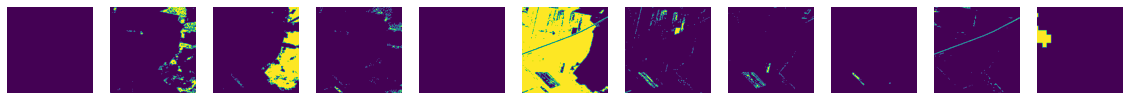

In [16]:
ncols = 11
nrows = 1

sample_n = 2

fig, axs = plt.subplots(
    nrows=1,
    ncols=ncols,
    figsize=(20, ncols * 6),
)

for i in range(ncols - 1):
    img = image[sample_n, i, :, :]
    img = torch.squeeze(img)
    axs[i].imshow(img)
    axs[i].axis("off")

msk = mask[sample_n, :, :, :]
msk = torch.squeeze(msk)
axs[10].imshow(msk)
axs[10].axis("off")

Questions/comments

1. How to deal with all the missing data?
2. How should we create the train/test/val splits? 
3. Are there any other transforms that should be performed (no need to normalise etc.)

## First go at using torchgeo segmentation task (this contains all the model and training logic)

In [11]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torchgeo.trainers import SemanticSegmentationTask

In [12]:
SemanticSegmentationTask?

Init signature: SemanticSegmentationTask(**kwargs: Any) -> None
Docstring:      LightningModule for semantic segmentation of images.
Init docstring:
Initialize the LightningModule with a model and loss function.

Keyword Args:
    segmentation_model: Name of the segmentation model type to use
    encoder_name: Name of the encoder model backbone to use
    encoder_weights: None or "imagenet" to use imagenet pretrained weights in
        the encoder model
    in_channels: Number of channels in input image
    num_classes: Number of semantic classes to predict
    loss: Name of the loss function
    ignore_zeros: Whether to ignore the "0" class value in the loss and metrics

Raises:
    ValueError: if kwargs arguments are invalid
File:           ~/miniconda3/envs/torchgeo/lib/python3.9/site-packages/torchgeo/trainers/__init__.py
Type:           type
Subclasses:     


In [13]:
task = SemanticSegmentationTask(
    segmentation_model="unet",
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=10,
    num_classes=2,
    loss="ce",
    ignore_zeros=True,
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
)

/home/users/sofijas/miniconda3/envs/torchgeo/lib/python3.9/site-packages/deprecate/deprecation.py:115: FutureWarning: The `IoU` was deprecated since v0.7 in favor of `torchmetrics.classification.jaccard.JaccardIndex`. It will be removed in v0.8.
  stream(template_mgs % msg_args)


In [14]:
fcn = SemanticSegmentationTask(
    segmentation_model="fcn",
    in_channels=10,
    num_classes=2,
    num_filters=64,
    loss="ce",
    ignore_zeros=True,
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
)

In [27]:
# experiment_dir = os.path.join(tempfile.gettempdir(), "results")

# checkpoint_callback = ModelCheckpoint(
#     monitor="val_loss",
#     dirpath=experiment_dir,
#     save_top_k=1,
#     save_last=True,
# )

# early_stopping_callback = EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.00,
#     patience=10,
# )

# csv_logger = CSVLogger(save_dir=experiment_dir, name="tutorial_logs")

In [15]:
trainer = pl.Trainer(
    logger=None,
    fast_dev_run=True,
    log_every_n_steps=1
    # callbacks=[checkpoint_callback, early_stopping_callback],
    # logger=[csv_logger],
    # default_root_dir=experiment_dir,
    # min_epochs=1,
    # max_epochs=5,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).


In [16]:
trainer.fit(model=fcn, datamodule=datamodule)


  | Name          | Type             | Params
---------------------------------------------------
0 | model         | FCN              | 153 K 
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
153 K     Trainable params
0         Non-trainable params
153 K     Total params
0.615     Total estimated model params size (MB)
/home/users/sofijas/miniconda3/envs/torchgeo/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


Validating: 0it [00:00, ?it/s]